In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas as pd
import os, pdb, re
import string
import stats

from keras import utils
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(linewidth=200,threshold=np.nan,formatter={'float_kind':float_formatter})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_colwidth",200)
pd.set_option("display.max_rows",200)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Preprocessing
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import keras.preprocessing.text as text
from keras.preprocessing import sequence

/Users/matt/kaggle/movie_sent/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
MAX_WORD_COUNT = 60
N_OUT = 5
BATCH_SIZE = 5
HIDDEN_SIZE = 32
NUM_LAYERS = 2
INIT_SCALE = 0.05

In [3]:
def sentence_clean( sentence ):
    review_text = BeautifulSoup(sentence).get_text() # 1. Remove HTML  
    letters_only = re.sub("[^a-zA-Z]", " ", sentence) #Remove non-letters
    words = letters_only.lower().split()    #Convert to lower case, split into individual words                          
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] #Remove stop words
    return( " ".join( meaningful_words )) #Join the words back into one string separated by space

# The Love Song of J. Alfred Prufrock

In [4]:
#def prufrock_df():
df = pd.read_table("The Love Song of J. Alfred Prufrock.txt",header=None,names=["Line"],dtype={"Line":str})
txt = df["Line"].values
df_clean = list(map(sentence_clean,txt))
pd.DataFrame({"before":txt,"after":df_clean})

/Users/matt/kaggle/movie_sent/venv/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /Users/matt/anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


,after,before
0,let us go,"Let us go then, you and I,"
1,evening spread sky,When the evening is spread out against the sky
2,like patient etherized upon table,Like a patient etherized upon a table;
3,let us go certain half deserted streets,"Let us go, through certain half-deserted streets,"
4,muttering retreats,The muttering retreats
5,restless nights one night cheap hotels,Of restless nights in one-night cheap hotels
6,sawdust restaurants oyster shells,And sawdust restaurants with oyster-shells:
7,streets follow like tedious argument,Streets that follow like a tedious argument
8,insidious intent,Of insidious intent
9,lead overwhelming question,To lead you to an overwhelming question ...


In [5]:
class Data_obj():
    def __init__(self,batch_size,clean_data):
        self.epoch = 1
        self.batch_size = batch_size
        self.clean_data = clean_data
        
        self.Tokenizer = text.Tokenizer()
        self.Tokenizer.fit_on_texts(self.clean_data)
        self.words = self.Tokenizer.word_index.keys()
        self.encoded_text = self.Tokenizer.texts_to_sequences(self.clean_data)
        
        self.inverse_tokenizer = lambda num: list(self.Tokenizer.word_index.keys())[list(self.Tokenizer.word_index.values()).index(num)] #inverse
        self.inverse_tokenizer_sentence = lambda sentence: list(map(self.inverse_tokenizer,sentence))
        
        self.vocab_size = len(self.Tokenizer.word_index) + 1
        print("There are {0} unique words in data set.".format(self.vocab_size))
        
    def shuffle(self):
        rng.shuffle(self.encoded_text)
        
    def new_batch(self):
        return np.zeros((self.batch_size,2)).astype(np.int32)
    
    def generator(self):
        self.i = self.k = 0
        self.shuffle()
        batch = self.new_batch()
        self.total_examples_seen = 0
        while True:
            self.current_sentence = self.encoded_text[self.i]
            sentence_len = len(self.current_sentence)
            if sentence_len < 2:
                self.i += 1
                if self.i >= len(self.encoded_text):
                    self.epoch += 1
                    self.i = 0
                    self.shuffle()
                continue
                
            for j in range(sentence_len):
                context = self.current_sentence[j]

                if j == 0:
                    target = self.current_sentence[j+1]
                elif j == sentence_len - 1:
                    target = self.current_sentence[j-1]
                elif rng.uniform() < 0.5:
                    target = self.current_sentence[j-1]
                else:
                    target = self.current_sentence[j+1]

                batch[self.k,0] = context
                batch[self.k,1] = target
                if self.k == BATCH_SIZE - 1:
                    self.k = 0
                    yield batch
                    batch = self.new_batch()
                    self.total_examples_seen += self.batch_size
                else:
                    self.k += 1
            self.i+=1
            if self.i >= len(self.encoded_text):
                self.epoch += 1
                self.i = 0
                self.shuffle()
            #shuffle after epoch
                

In [12]:
data_obj = Data_obj(batch_size=BATCH_SIZE,clean_data=df_clean)
generate_batch = data_obj.generator()
for i in range(2):
    data = next(generate_batch)
    print(data_obj.current_sentence,data_obj.inverse_tokenizer_sentence(data_obj.current_sentence))
    for i in data:
        print(i,data_obj.inverse_tokenizer_sentence(i))

There are 338 unique words in data set.
[93, 94, 95, 96] ['sawdust', 'restaurants', 'oyster', 'shells']
[23 37] ['room', 'women']
[37 15] ['women', 'come']
[15  6] ['come', 'go']
[ 6 15] ['go', 'come']
[93 94] ['sawdust', 'restaurants']
[223, 224, 225] ['smoothed', 'long', 'fingers']
[94 95] ['restaurants', 'oyster']
[95 96] ['oyster', 'shells']
[96 95] ['shells', 'oyster']
[223 224] ['smoothed', 'long']
[224 223] ['long', 'smoothed']


## Embedding layer - Turns positive integers (indexes) into dense vectors of fixed size”

In [28]:
vocabulary_size = data_obj.vocab_size
embedding_size = HIDDEN_SIZE
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_context = tf.placeholder(tf.int32, shape=[None, 1])
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

#NCE Loss
nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
hidden_out = tf.matmul(embed, tf.transpose(nce_weights)) + nce_biases
soft_max = tf.nn.softmax(hidden_out)
loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=1,
                       num_classes=vocabulary_size))
# Optimization 
learning_rate = tf.placeholder(tf.float32)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
saver = tf.train.Saver()
model_path = "/tmp/model.ckpt"

#cosine similarity
embedding_norm=tf.nn.l2_normalize(embeddings,axis=1)
similarity = tf.matmul(embedding_norm, tf.transpose(embedding_norm))

In [34]:
load = True
with tf.Session() as sess:
    if load == True:
        saver.restore(sess,model_path)
    else:
        init = tf.global_variables_initializer()
        sess.run(init)
    embeddings_before = embeddings.eval()
    data_obj = Data_obj(batch_size=BATCH_SIZE,clean_data=df_clean)
    generate_batch = data_obj.generator()
    cur_losses = []
    lr = 0.2
    while True:
        data = next(generate_batch)
        feed_dict = {train_inputs: data[:,0],train_context:data[:,[1]],learning_rate:lr}
        _, cur_loss = sess.run([optimizer, loss], feed_dict=feed_dict)
        cur_losses.append(cur_loss)
        if data_obj.total_examples_seen % 2000 == 0:
            print("{0} seen with running loss of {1:.3f}. Current epoch = {2}. Current lr = {3:.3f}".format(data_obj.total_examples_seen,np.mean(cur_losses),data_obj.epoch,lr))
            cur_losses = []
            lr /= 1.0
        if data_obj.epoch == 50:
            print("Finished.")
            break
    save_path = saver.save(sess,model_path )
    learnt_embeddings = embeddings.eval()

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
There are 338 unique words in data set.
0 seen with running loss of 0.089. Current epoch = 1. Current lr = 0.200
2000 seen with running loss of 0.142. Current epoch = 5. Current lr = 0.200
4000 seen with running loss of 0.134. Current epoch = 9. Current lr = 0.200
6000 seen with running loss of 0.155. Current epoch = 13. Current lr = 0.200
8000 seen with running loss of 0.147. Current epoch = 17. Current lr = 0.200
10000 seen with running loss of 0.139. Current epoch = 21. Current lr = 0.200
12000 seen with running loss of 0.135. Current epoch = 25. Current lr = 0.200
14000 seen with running loss of 0.141. Current epoch = 29. Current lr = 0.200
16000 seen with running loss of 0.148. Current epoch = 34. Current lr = 0.200
18000 seen with running loss of 0.160. Current epoch = 38. Current lr = 0.200
20000 seen with running loss of 0.131. Current epoch = 42. Current lr = 0.200
22000 seen with running loss of 0.129. Current epoch = 

In [52]:
def df_examples(word,df_clean):
    for sentence in df_clean:
        words = sentence.split(" ")
        if word in sentence:
            print(sentence)

with tf.Session() as sess:
    saver.restore(sess,model_path)
    top_n_words = 3
    cosine_similarity = similarity.eval()
    for word_no in range(1,vocabulary_size):
        word = data_obj.inverse_tokenizer(word_no)
        feed_dict={train_inputs:np.array([word_no])}
        word_embed, word_pred = sess.run([embed,soft_max],feed_dict)
        word_pred = word_pred.squeeze()
        top_n_args = word_pred.argsort()[-top_n_words:]
        print("\n")
        print(word,word_no)
        #print(word_pred)
        print(data_obj.inverse_tokenizer_sentence(top_n_args))
        df_examples(word,df_clean)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


time 1
['murder', 'indeed', 'time']
indeed time
time time
time murder create
time works days hands
time time
time yet hundred indecisions
indeed time
time turn back descend stair
minute time
times indeed almost ridiculous
almost times fool


upon 2
['table', 'fall', 'window']
like patient etherized upon table
yellow fog rubs back upon window panes
lingered upon pools stand drains
let fall upon back soot falls chimneys
rubbing back upon window panes
though seen head grown slightly bald brought upon platter
shall wear white flannel trousers walk upon beach


say 3
['hair', 'shall', 'window']
say hair growing thin
say arms legs thin
shall say gone dusk narrow streets
say lazarus come dead
say meant
impossible say mean
turning toward window say


known 4
['eyes', 'arms', 'already']
known already known
known evenings mornings afternoons
known eyes already known
known arms already known


back 5
['soot', 'blown', 'tell']
yellow fog 

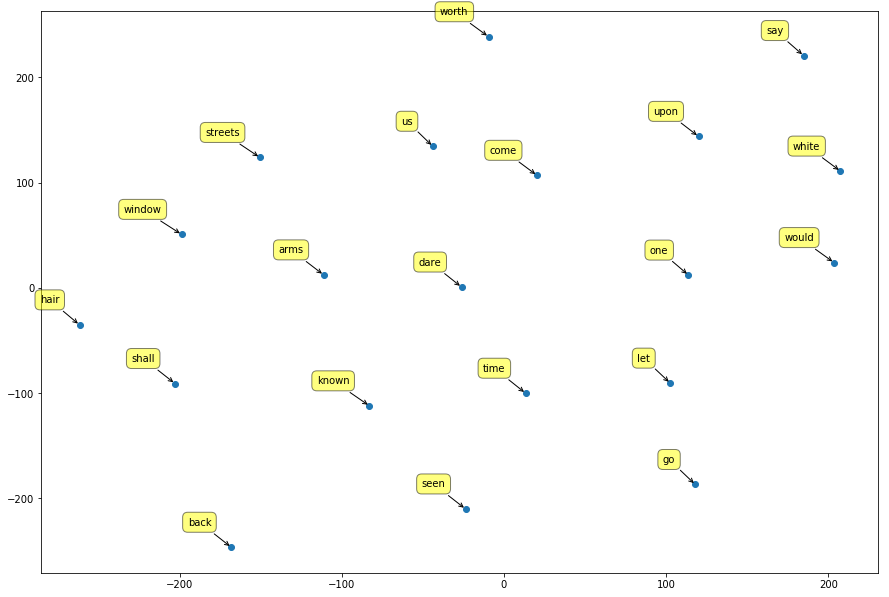

In [77]:
n_words_display = 20 # look at first n_words_display embedded
pca = TSNE(n_components=2,perplexity=10)
reduced_embeddings = pca.fit_transform(learnt_embeddings[1:n_words_display+1]) #first embedding is meaningless (cant index it)
labels = [data_obj.inverse_tokenizer(word_no) for word_no in range(1,vocabulary_size)[:n_words_display]]

plt.figure(figsize=(15,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o',
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, reduced_embeddings[:, 0], reduced_embeddings[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

In [72]:
pca.explained_variance_ratio_

array([0.15, 0.11], dtype=float32)